In [80]:
from u2net import U2NET
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from skimage import transform
from umap import UMAP

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
all_images_rgb = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        tf_image = tf.expand_dims(image_gray / 255, 2)
    #    tf_rgb = tf.image.grayscale_to_rgb(tf_image)
        tf_preproc = tf.image.resize(tf_image, (1024, 1024))
        all_images_rgb.append(tf_preproc)

all_images_rgb = np.array(all_images_rgb)

In [3]:
image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)
model = tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')

In [4]:
model.summary()

Model: "u2netmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
u2net (U2NET)                ((None, 1024, 1024, 1), ( 44037517  
Total params: 44,037,517
Trainable params: 44,008,717
Non-trainable params: 28,800
_________________________________________________________________


In [5]:
N=50
x_train, x_test, y_train, y_test = train_test_split(  all_images_rgb[:N],all_images_rgb[:N], test_size=0.2, )

In [7]:
model.compile(optimizer='adam', loss='MSE', metrics=['MAE'])
history=model.fit(x_train, y_train,
                        epochs=15,
                        batch_size=1,
                        shuffle=True,
                        validation_data=(x_test, x_test))

Epoch 1/15
40/40 [==============================] - 73s 484ms/step - loss: 0.0453 - MAE: 0.1429 - val_loss: 0.1110 - val_MAE: 0.2844
Epoch 2/15
40/40 [==============================] - 18s 441ms/step - loss: 0.0044 - MAE: 0.0357 - val_loss: 0.0250 - val_MAE: 0.1280
Epoch 3/15
40/40 [==============================] - 18s 457ms/step - loss: 0.0022 - MAE: 0.0219 - val_loss: 0.1155 - val_MAE: 0.2960
Epoch 4/15
40/40 [==============================] - 18s 442ms/step - loss: 0.0027 - MAE: 0.0233 - val_loss: 0.0190 - val_MAE: 0.0935
Epoch 5/15
40/40 [==============================] - 18s 448ms/step - loss: 0.0011 - MAE: 0.0168 - val_loss: 0.0186 - val_MAE: 0.1002
Epoch 6/15
40/40 [==============================] - 18s 461ms/step - loss: 9.1321e-04 - MAE: 0.0161 - val_loss: 0.0172 - val_MAE: 0.0925
Epoch 7/15
40/40 [==============================] - 18s 443ms/step - loss: 8.0262e-04 - MAE: 0.0159 - val_loss: 0.0154 - val_MAE: 0.0813
Epoch 8/15
40/40 [==============================] - 18s 442ms

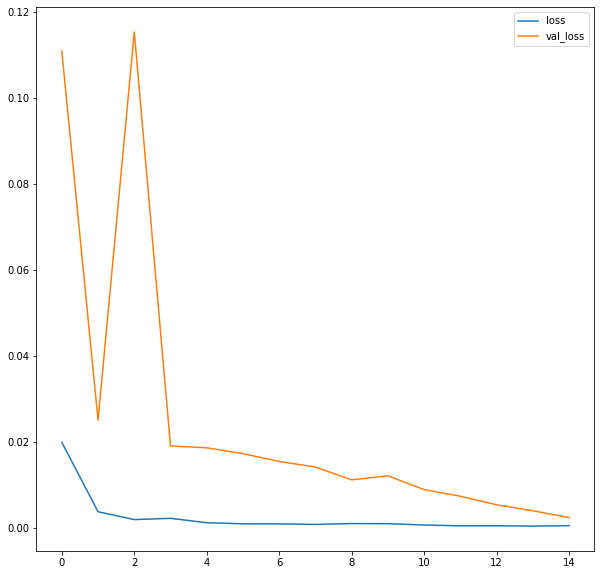

In [20]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

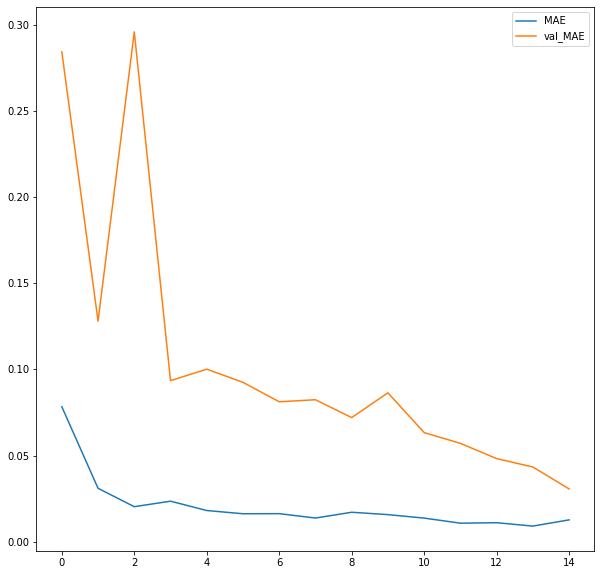

In [19]:
plt.figure(figsize=(10,10))
plt.plot(history.history['MAE'])
plt.plot(history.history['val_MAE'])
plt.legend(['MAE','val_MAE'])
plt.show()

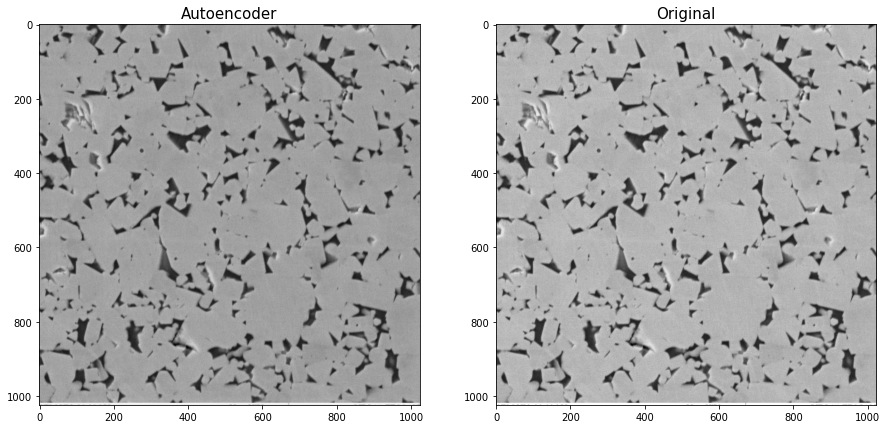

In [64]:
#predict=model.predict(tf.expand_dims(all_images_rgb[0],axis=0))[0]
predict=net(tf.expand_dims(x_test[0],axis=0))[0][0]

original=x_test[0]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(predict,cmap='gray')
ax1.set_title('Autoencoder',fontsize=15)

ax2.imshow(original,cmap='gray')
ax2.set_title('Original',fontsize=15)
plt.savefig('autoencoder_test.png')
plt.show()

In [92]:
net(tf.expand_dims(all_images_rgb[0],axis=0))[1][0].numpy().flatten().shape

(1024,)

In [95]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
images_embs = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        resized = transform.resize(image_gray, (1024, 1024,1))
        emb=net(tf.expand_dims(resized,axis=0))[1][0].numpy().flatten()
        images_embs.append(emb)

In [96]:
umap_news=UMAP()
umaped_vct=umap_news.fit_transform(images_embs)

In [116]:
color_indeces=[len(all_images[0]),
               len(all_images[0])+len(all_images[1]),
               len(all_images[0])+len(all_images[1])+len(all_images[2]),
               len(all_images[0])+len(all_images[1])+len(all_images[2])+len(all_images[3]),
               len(all_images[0])+len(all_images[1])+len(all_images[2])+len(all_images[3])+len(all_images[4])]

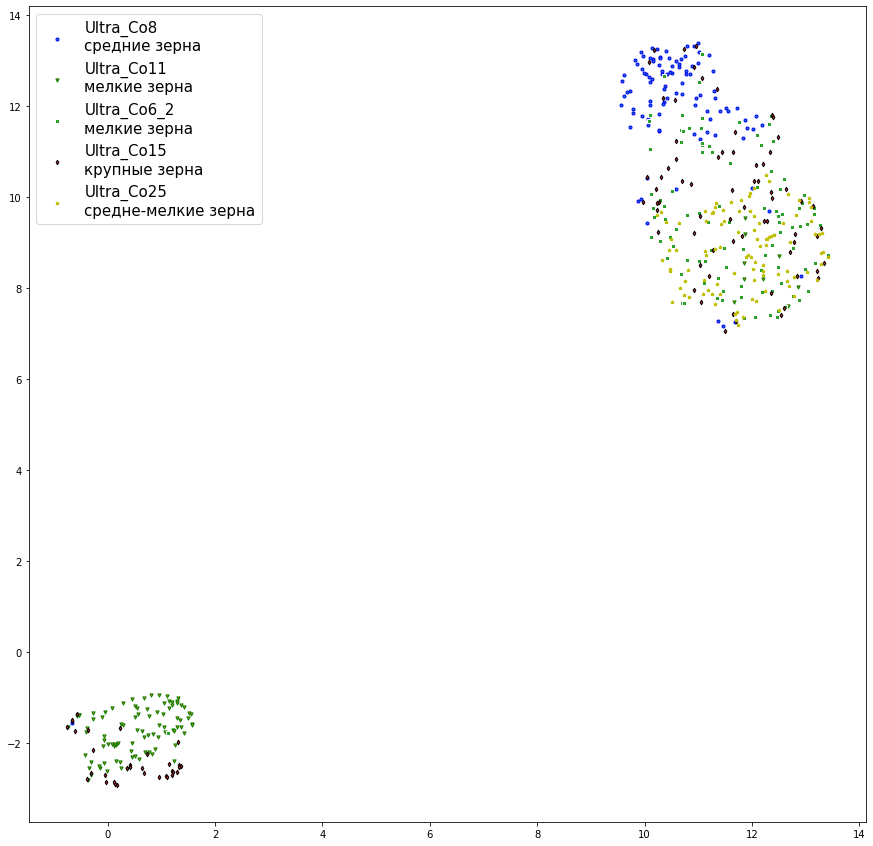

In [138]:
N=15
fig, ax = plt.subplots(figsize=(N,N))
size=10

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна', 'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']


ax.scatter(umaped_vct[:color_indeces[0], 0], umaped_vct[:color_indeces[0], 1],edgecolor='b', s=size,marker='8')
ax.scatter(umaped_vct[color_indeces[0]:color_indeces[1], 0], umaped_vct[color_indeces[0]:color_indeces[1], 1],edgecolor='g', s=size,marker='v')
ax.scatter(umaped_vct[color_indeces[1]:color_indeces[2], 0], umaped_vct[color_indeces[1]:color_indeces[2], 1],edgecolor='w', s=size,marker='s')
ax.scatter(umaped_vct[color_indeces[2]:color_indeces[3], 0], umaped_vct[color_indeces[2]:color_indeces[3], 1],edgecolor='k', s=size,marker='d')
ax.scatter(umaped_vct[color_indeces[3]:, 0], umaped_vct[color_indeces[3]:, 1],edgecolor='y', s=size,marker='*')
ax.legend(names,fontsize=15)
plt.savefig('embs_space.png')
plt.show()

In [114]:
umaped_vct[color_indeces[2]:color_indeces[3]]

array([], shape=(0, 2), dtype=float32)